In [700]:
# import modules
import numpy as np
import astropy.units as u
import astropy.table as tbl

# import plotting modules
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# import constants
from astropy import constants as const

# import functions
from ReadFile import Read
from CenterOfMass import CenterOfMass

In [702]:
class MassProfile:
# Class to calculate the mass profile of a given galaxy and simulation snapshot 
    
    def __init__(self, galaxy, snap):
        ''' Class to calculate the mass distribution of a galaxy at a certain SnapNumber and
        use this to determine that galaxy's rotation curve. 
            
            PARAMETERS
            ----------
            galaxy : `str`
                galaxy name
            snap : `int`
                snapshot number
        '''
        # add a string of a filenumber to the value "000"
        ilbl = '000'+str(snap)
        # remove all but the last three digits
        ilbl = ilbl[-3:]
        self.filename = "%s_"%(galaxy)+ilbl+'.txt'
        # read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename)
        # store the mass and positions of the particles
        self.m = self.data['m']
        self.x = self.data['x']*u.kpc
        self.y = self.data['y']*u.kpc
        self.z = self.data['z']*u.kpc
        # store the name of the galaxy
        self.gname = galaxy
        
    def MassEnclosed(self, ptype, r):
        ''' Method to compute the mass enclosed of a specified particle type at different radii.
        
        PARAMETERS
        ----------
        ptype : `int; 1, 2, or 3`
            particle type to use for mass enclosed calculations
        r : `np.array of floats`
            array of radii to find enclosed masses at
        
        RETURNS
        -------
        m_enc : `np.array of floats`
            array of total mass enclosed at each radii for the particle type
        '''
        # calculate the centre of mass
        COM = CenterOfMass(self.filename, ptype)
        index = np.where(self.data['type'] == ptype)
        COM_p = COM.COM_P(0.1)
        # store the masses and positions of the particles relative the centre of mass
        pmass = self.m[index]
        px = self.x[index]-COM_p[0]
        py = self.y[index]-COM_p[1]
        pz = self.z[index]-COM_p[2]
        # calculate the radius of the particles
        pr = np.sqrt(px**2+py**2+pz**2)
        # initialize array to store the masses
        m_enc = np.zeros_like(r)
        # loop through each radius value
        for i, j in enumerate(r):
            # find all particles within current radius
            r_enc = np.where(pr.value<j)
            # store masses of particles
            rmass = pmass[r_enc]
            # sum all masses
            m_enc[i] = np.sum(rmass)
        # set correct astropy units
        m_enc = m_enc*10**10*u.Msun
        # return mass enclosed array
        return m_enc

    def MassEnclosedTotal(self, r):
        ''' Method to compute the total mass enclosed at different radii.
        
        PARAMETERS
        ----------
        r : `np.array of floats`
            array of radii to find enclosed masses at
        
        RETURNS
        -------
        m_tot : `np.array of floats`
            array of total mass enclosed at each radii
        '''
        # determine if there are 2 or 3 particle types
        if self.gname == "M33":
            # add the arrays of the different particle types together
            m_tot = self.MassEnclosed(1,r)+self.MassEnclosed(2,r)
        else:
            # add the arrays of the different particle types together
            m_tot = self.MassEnclosed(1,r)+self.MassEnclosed(2,r)+self.MassEnclosed(3,r)
        # return array of total enclosed mass
        return m_tot

    def HernquistMass(self, r, a, m_halo):
        """ Method that defines the Hernquist 1990 mass profile 
        
        PARAMETERS
        ----------
            r: astropy quantity
                Galactocentric distance in kpc
            a: astropy quantity
                scale radius of the Hernquist profile in kpc
            m_halo: np.array of floats
                halo masses in units of 1e12 Msun 
            
        RETURNS
        -------
            Hmass: np.array of floats
                mass within the input radius r in Msun
        """
        # correct units
        m = m_halo*10**2
        n = r**2/(a+r)**2
        Hmass = m*n #Hernquist profile   
        return Hmass

    def CircularVelocity(self,ptype,r):
        ''' Method to compute the circular velocity of a specified particle type at different radii.
        
        PARAMETERS
        ----------
        ptype : `int; 1, 2, or 3`
            particle type to use for mass enclosed calculations
        r : `np.array of floats`
            array of radii to find enclosed masses at
        
        RETURNS
        -------
        vcirc : `np.array of floats`
            array of circular velocity at each radii for the particle type
        '''
        # correct units
        Grav = (const.G.to(u.kpc*u.km**2/u.s**2/u.Msun)).value
        # initialize array to store the velocities
        vcirc = np.zeros_like(r)
        # calculate the relevant masses at the radii
        mtot = self.MassEnclosed(ptype,r)
        # loop through each radius value
        for i, j in enumerate(r):
            # calculate the circular velocity
            vcirc[i] = np.sqrt(Grav*mtot[i].value/j)
        # set correct astropy units
        vcirc = vcirc*(u.km/u.s)
        # return array of circular velocities
        return vcirc

    def CircularVelocityTotal(self,r):
        ''' Method to compute the total circular velocity at different radii.
        
        PARAMETERS
        ----------
        r : `np.array of floats`
            array of radii to find enclosed masses at
        
        RETURNS
        -------
        v_tot : `np.array of floats`
            array of total circular velocity at each radii
        '''
        # correct units
        Grav = const.G.to(u.kpc*u.km**2/u.s**2/u.Msun).value
        # calculate the total mass at the radii
        mass = self.MassEnclosedTotal(r)
        # initialize array to store the velocities
        v_tot = np.zeros_like(r)
        # loop through each radius value
        for i, j in enumerate(r):
            # calculate the circular velocity
            v_tot[i] = np.sqrt(Grav*mass[i].value/j)
        # set correct astropy units
        v_tot = v_tot*(u.km/u.s)
        # return array of circular velocities
        return v_tot
        
    def HernquistVCirc(self, r, a, m_halo):
        """ Method that calculates the circular velocity using the Hernquist 1990 mass profile
        
        PARAMETERS
        ----------
            r: astropy quantity
                Galactocentric distance in kpc
            a: astropy quantity
                scale radius of the Hernquist profile in kpc
            m_halo: np.array of floats
                halo masses in units of 1e12 Msun 
            
        RETURNS
        -------
            Hvel: np.array of floats
                circular velocity within the input radius r in km/s
        """
        # correct units
        Grav = const.G.to(u.kpc*u.km**2/u.s**2/u.Msun)
        # calculate the circular velocity
        Hvel = np.sqrt(Grav*self.HernquistMass(r,a,m_halo)/r)
        # return array of circular velocities
        return Hvel

In [704]:
# Create a mass profile object for the MW, M31, and M33
MW_MP = MassProfile("MW", 0)
M31_MP = MassProfile("M31", 0)
M33_MP = MassProfile("M33", 0)

In [706]:
# Define r array
step = np.arange(0.1,30,0.1)

In [708]:
# Calculate and store the mass enclosed for each particle type
MW_MP_h = MW_MP.MassEnclosed(1,step)
MW_MP_d = MW_MP.MassEnclosed(2,step)
MW_MP_b = MW_MP.MassEnclosed(3,step)
# Calculate and store the total mass enclosed
MW_MP_t = MW_MP.MassEnclosedTotal(step)
# Calculate and store the Hernquist mass
MW_MP_H = MW_MP.HernquistMass(30,270,MW_MP_h)

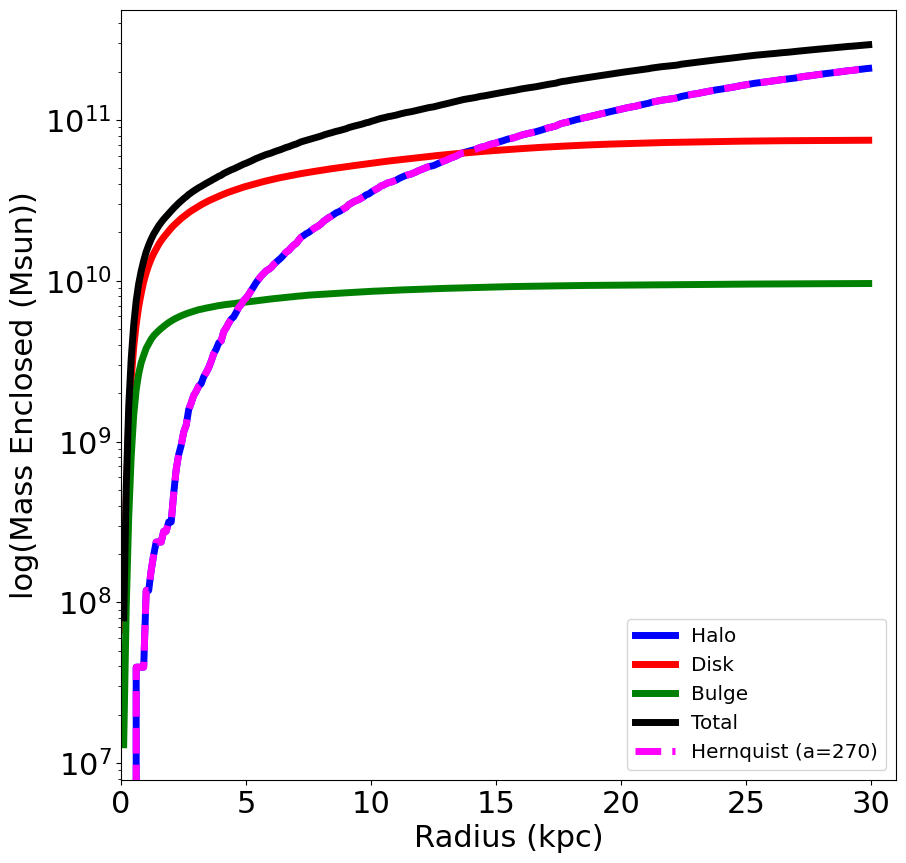

In [709]:
# Plot the mass profiles of the MW components
fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the values (y axis log)
ax.semilogy(step,MW_MP_h,color='blue',linewidth=5,label='Halo')
ax.semilogy(step,MW_MP_d,color='red',linewidth=5,label='Disk')
ax.semilogy(step,MW_MP_b,color='green',linewidth=5,label='Bulge')
ax.semilogy(step,MW_MP_t,color='black',linewidth=5,label='Total')
ax.semilogy(step,MW_MP_H,color='magenta',linewidth=5,linestyle='--',label='Hernquist (a=270)')

# Add labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('log(Mass Enclosed (Msun))', fontsize=22)

#set axis limits
plt.xlim(0,31)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# Save to a file
plt.savefig('MW_Enclosed.png')

In [712]:
# Calculate and store the mass enclosed for each particle type
M31_MP_h = M31_MP.MassEnclosed(1,step)
M31_MP_d = M31_MP.MassEnclosed(2,step)
M31_MP_b = M31_MP.MassEnclosed(3,step)
# Calculate and store the total mass enclosed
M31_MP_t = M31_MP.MassEnclosedTotal(step)
# Calculate and store the Hernquist mass
M31_MP_H = M31_MP.HernquistMass(30,270,M31_MP_h)

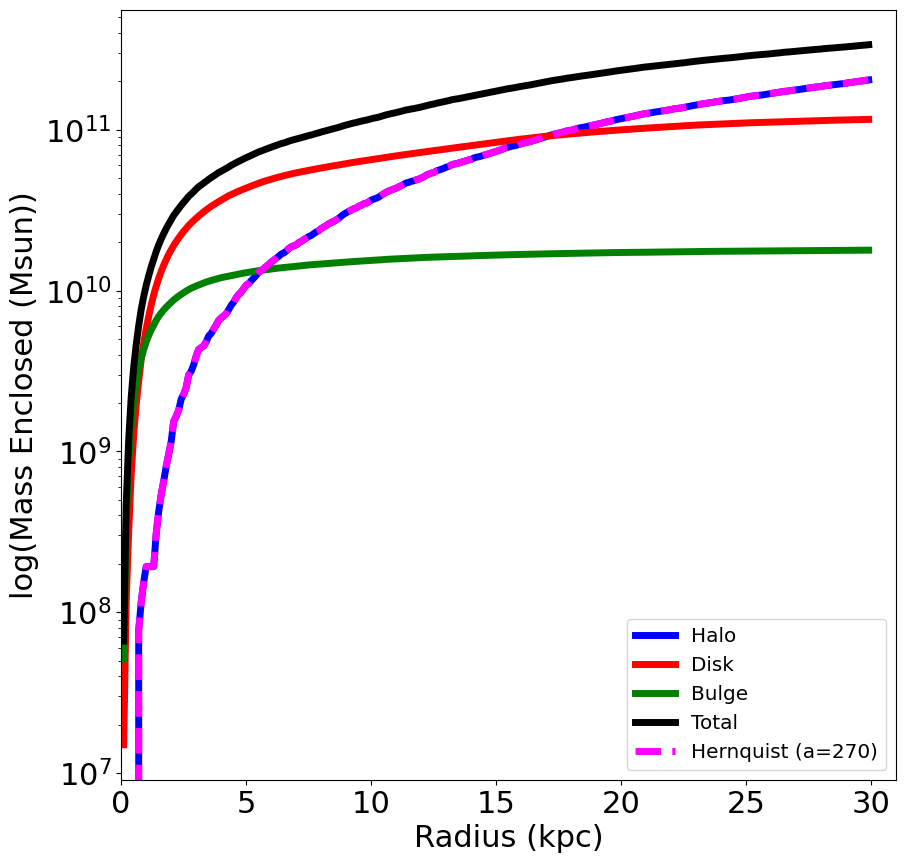

In [714]:
# Plot the mass profiles of the M31 components
fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the values (y axis log)
ax.semilogy(step,M31_MP_h,color='blue',linewidth=5,label='Halo')
ax.semilogy(step,M31_MP_d,color='red',linewidth=5,label='Disk')
ax.semilogy(step,M31_MP_b,color='green',linewidth=5,label='Bulge')
ax.semilogy(step,M31_MP_t,color='black',linewidth=5,label='Total')
ax.semilogy(step,M31_MP_H,color='magenta',linewidth=5,linestyle='--',label='Hernquist (a=270)')

# Add labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('log(Mass Enclosed (Msun))', fontsize=22)

#set axis limits
plt.xlim(0,31)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# Save to a file
plt.savefig('M31_Enclosed.png')

In [716]:
# Calculate and store the mass enclosed for each particle type
M33_MP_h = M33_MP.MassEnclosed(1,step)
M33_MP_d = M33_MP.MassEnclosed(2,step)
# Calculate and store the total mass enclosed
M33_MP_t = M33_MP.MassEnclosedTotal(step)
# Calculate and store the Hernquist mass
M33_MP_H = M33_MP.HernquistMass(30,270,M33_MP_h)

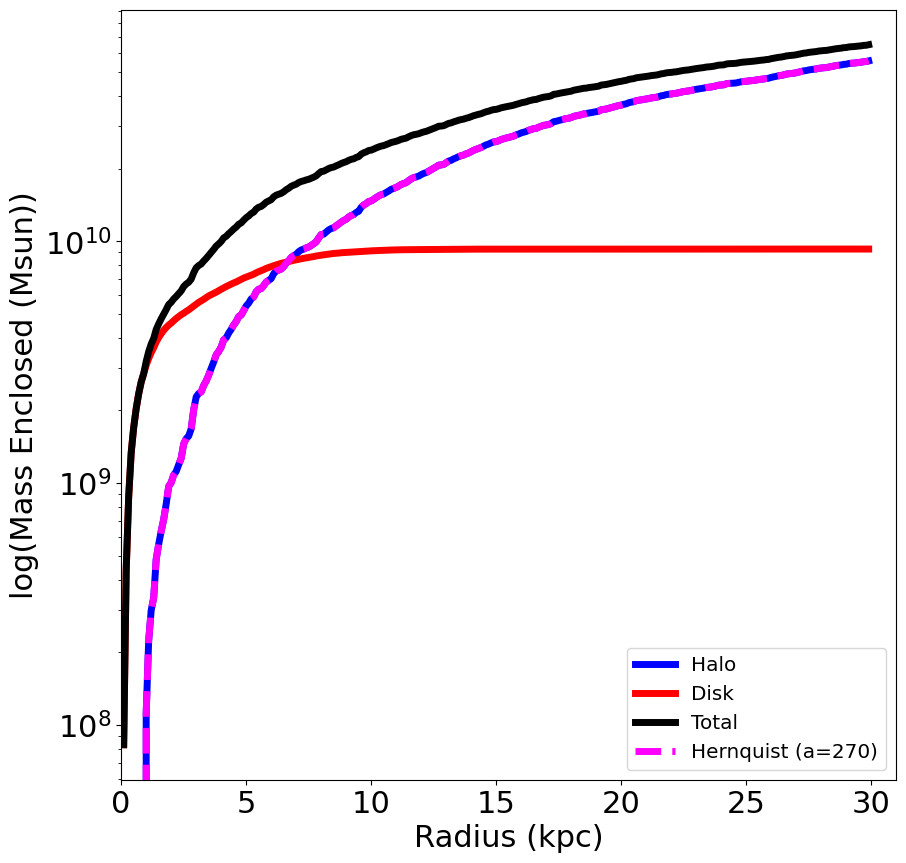

In [718]:
# Plot the mass profiles of the M33 components
fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the values (y axis log)
ax.semilogy(step,M33_MP_h,color='blue',linewidth=5,label='Halo')
ax.semilogy(step,M33_MP_d,color='red',linewidth=5,label='Disk')
ax.semilogy(step,M33_MP_t,color='black',linewidth=5,label='Total')
ax.semilogy(step,M33_MP_H,color='magenta',linewidth=5,linestyle='--',label='Hernquist (a=270)')

# Add labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('log(Mass Enclosed (Msun))', fontsize=22)

#set axis limits
plt.xlim(0,31)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# Save to a file
plt.savefig('M33_Enclosed.png')

In [720]:
# Calculate and store the circular velocity for each particle type
MW_CV_h = MW_MP.CircularVelocity(1,step)
MW_CV_d = MW_MP.CircularVelocity(2,step)
MW_CV_b = MW_MP.CircularVelocity(3,step)
# Calculate and store the total circular velocity
MW_CV_t = MW_MP.CircularVelocityTotal(step)
# Calculate and store the Hernquist circular velocity
MW_CV_H = MW_MP.HernquistVCirc(30,270,MW_MP_h)

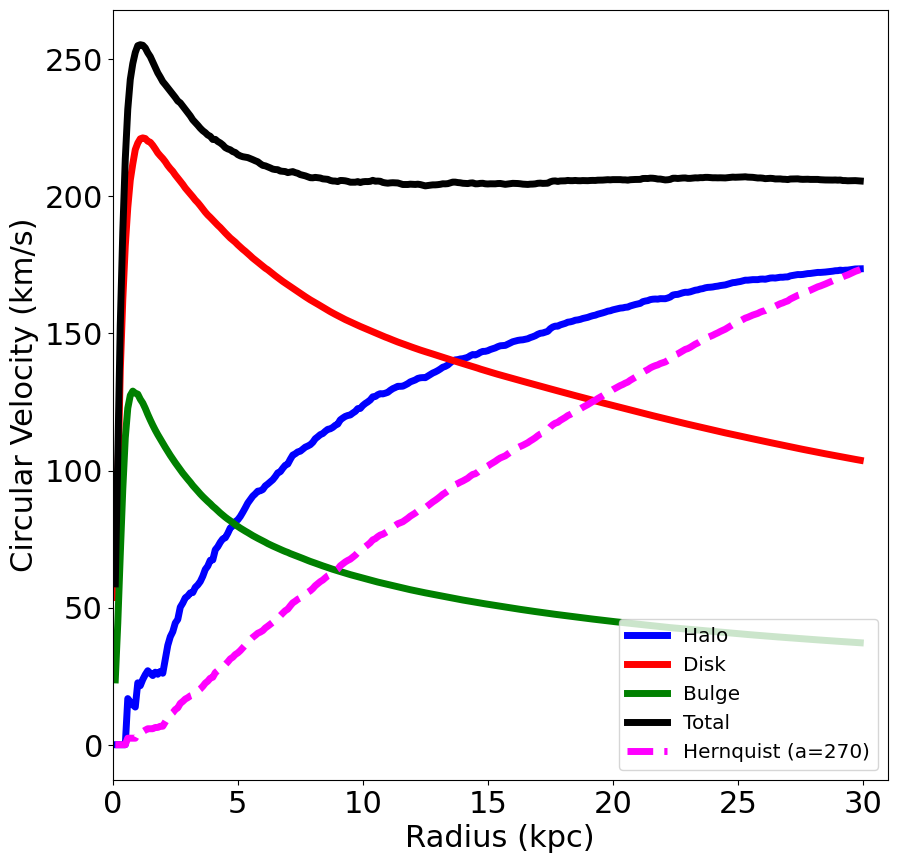

In [722]:
# Plot the rotation curves of the MW components
fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the values
ax.plot(step,MW_CV_h,color='blue',linewidth=5,label='Halo')
ax.plot(step,MW_CV_d,color='red',linewidth=5,label='Disk')
ax.plot(step,MW_CV_b,color='green',linewidth=5,label='Bulge')
ax.plot(step,MW_CV_t,color='black',linewidth=5,label='Total')
ax.plot(step,MW_CV_H,color='magenta',linewidth=5,linestyle='--',label='Hernquist (a=270)')

# Add labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('Circular Velocity (km/s)', fontsize=22)

#set axis limits
plt.xlim(0,31)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# Save to a file
plt.savefig('MW_RCurve.png')

In [724]:
# Calculate and store the circular velocity for each particle type
M31_CV_h = M31_MP.CircularVelocity(1,step)
M31_CV_d = M31_MP.CircularVelocity(2,step)
M31_CV_b = M31_MP.CircularVelocity(3,step)
# Calculate and store the total circular velocity
M31_CV_t = M31_MP.CircularVelocityTotal(step)
# Calculate and store the Hernquist circular velocity
M31_CV_H = M31_MP.HernquistVCirc(30,270,M31_MP_h)

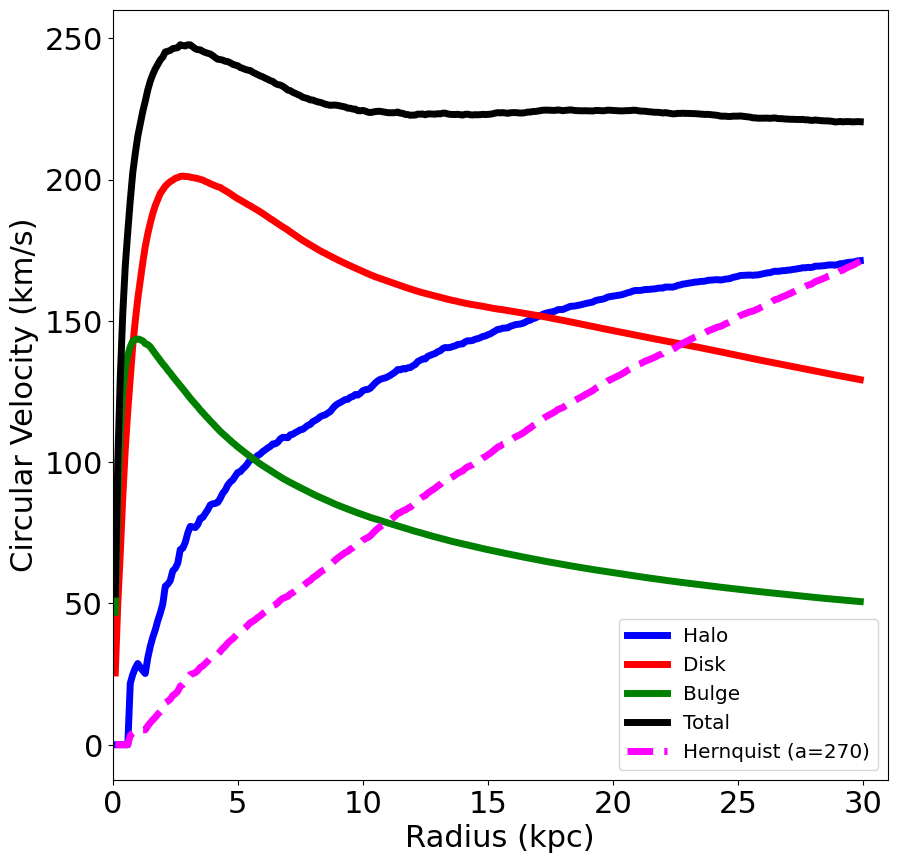

In [726]:
# Plot the rotation curves of the M31 components
fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the values
ax.plot(step,M31_CV_h,color='blue',linewidth=5,label='Halo')
ax.plot(step,M31_CV_d,color='red',linewidth=5,label='Disk')
ax.plot(step,M31_CV_b,color='green',linewidth=5,label='Bulge')
ax.plot(step,M31_CV_t,color='black',linewidth=5,label='Total')
ax.plot(step,M31_CV_H,color='magenta',linewidth=5,linestyle='--',label='Hernquist (a=270)')

# Add labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('Circular Velocity (km/s)', fontsize=22)

#set axis limits
plt.xlim(0,31)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# Save to a file
plt.savefig('M31_RCurve.png')

In [728]:
# Calculate and store the circular velocity for each particle type
M33_CV_h = M33_MP.CircularVelocity(1,step)
M33_CV_d = M33_MP.CircularVelocity(2,step)
# Calculate and store the total circular velocity
M33_CV_t = M33_MP.CircularVelocityTotal(step)
# Calculate and store the Hernquist circular velocity
M33_CV_H = M33_MP.HernquistVCirc(30,270,M33_MP_h)

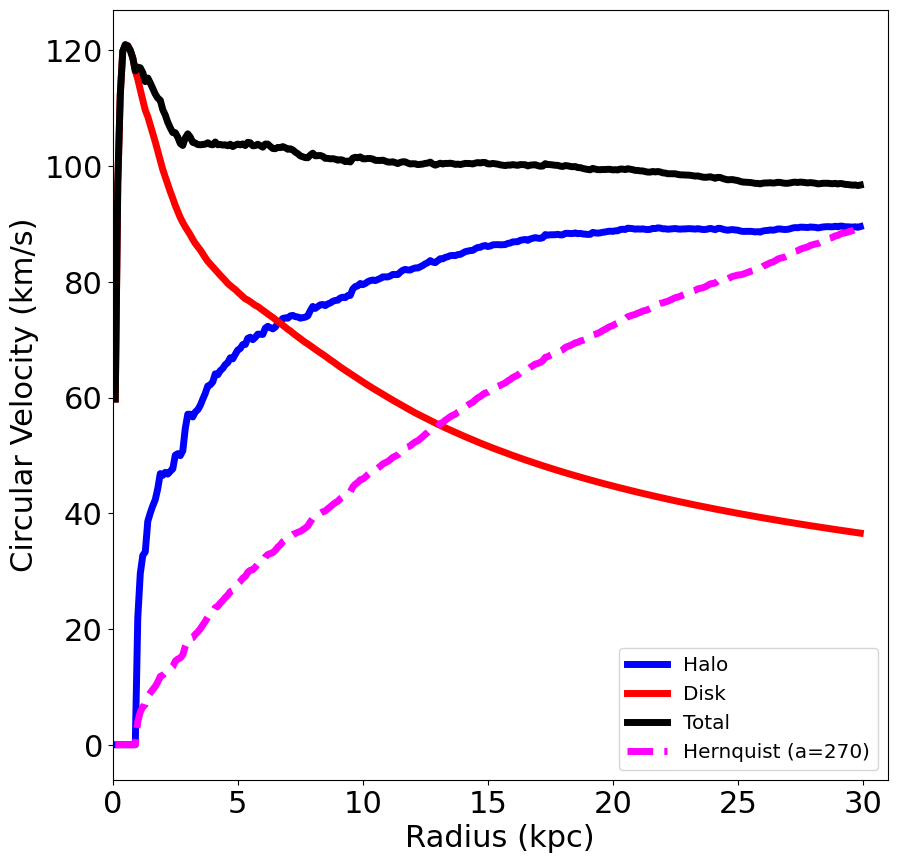

In [730]:
# Plot the rotation curves of the M33 components
fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the values
ax.plot(step,M33_CV_h,color='blue',linewidth=5,label='Halo')
ax.plot(step,M33_CV_d,color='red',linewidth=5,label='Disk')
ax.plot(step,M33_CV_t,color='black',linewidth=5,label='Total')
ax.plot(step,M33_CV_H,color='magenta',linewidth=5,linestyle='--',label='Hernquist (a=270)')

# Add labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('Circular Velocity (km/s)', fontsize=22)

#set axis limits
plt.xlim(0,31)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# Save to a file
plt.savefig('M33_RCurve.png')